In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pdfminer
import glob
import scipy
import math
import random

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
from sklearn.feature_extraction.text import CountVectorizer
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer

## Q1

Shannon's paper "A Mathematical Theory of Communication", aims to tackle a fundamental problem of communication (as of 1948) relating to noiseless communication systems. The first part of the paper provides a brief intuition for the choice of the logarithmic function for information transfer, and then defines a communication system in terms of five components. The first two components are information source which provides the information to be transmit, and transmitter, which encodes the message in the form of a signal that can be transmit. The last two components are receiver and destination, which are the inverse of the transmitter and source, respectively. The transmitter and receiver are connected by a channel which is the medium used to transmit the signal, and that is where noise is likely to be introduced.
The next few subsections look at the mathematial properties of discrete noiseless systems. Starting with the capacity of a channel, there is a brief discussion on allowable sequences, sources of information, approximations and n-grams. Generally, these sections try to lay the foundation for modern natural language processing (NLP), by talking about series of approximations to english, establishing sentences as a Markov (Markoff?) process and specifically, ergodic processes.
After this formulation, a measure of uncertainity is introduced. This measure is entropy, and it has to follow three properties relating to the probaility distribution, i.e., continuity, monotonically increasing funcion of number of choices and indifference to successive choices. The only function satisfying said properties is the proposed "Shannon" formula which defines entropy as:
$H = -K \Sigma_{i=1}^n p_i logp_i$
A few properties of this formula are explored such as behavior at extremes, behavior under joint distributions, conditional entropy, etc. The last few subsections talk about application of entropy to an information source, and how encoding/decoding operations can be represented to minimize the number of required bits. The fundamental theorem for a noiseless channel provides a hard upper bound for the avergae symbols per second transmitted for a given channel. Lastly, an example is provided to show how the average number of bits is obtained for a toy example with a special encoding scheme.

## Q2

Scraping, Entropy and ICML papers
ICML is a top research conference in Machine learning. Scrape all the pdfs of all ICML 2017 papers from http://proceedings.mlr.press/v70/.
1. What are the top 10 common words in the ICML papers?
2. Let Z be a randomly selected word in a randomly selected ICML paper. Estimate the entropy of Z.
3. Synthesize a random paragraph using the marginal distribution over words.
4. (Extra credit) Synthesize a random paragraph using an n-gram model on words. Synthesize a random paragraph using any model you want. Top five synthesized text paragraphs win bonus (+30 points).

#### Preprocessing

In [2]:
class PdfConverter:

   def __init__(self, file_path):
       self.file_path = file_path
# convert pdf file to a string which has space among words 
   def convert_pdf_to_txt(self):
       rsrcmgr = PDFResourceManager()
       retstr = StringIO()
       codec = 'utf16' #,'utf-8'
       laparams = LAParams()
       device = TextConverter(rsrcmgr, retstr, laparams=laparams)
       fp = open(self.file_path, 'rb')
       interpreter = PDFPageInterpreter(rsrcmgr, device)
       password = ""
       maxpages = 0
       caching = True
       pagenos = set()
       for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password, caching=caching, check_extractable=True):
           interpreter.process_page(page)
       fp.close()
       device.close()
       str = retstr.getvalue()
       retstr.close()
       return str
# convert pdf file text to string and save as a text_pdf.txt file
   def save_convert_pdf_to_txt(self):
       content = self.convert_pdf_to_txt()
       txt_pdf = open('text_pdf.txt', 'ab')
       txt_pdf.write(content.encode('utf-8'))
       txt_pdf.close()
        
pdflist = glob.glob("/Users/cgokalp/Dropbox/ICML Papers/*.pdf")

for pdf in pdflist:
#     print("Working on: " + pdf + '\n')
    pdfConverter = PdfConverter(file_path=pdf)
    #print(pdfConverter.convert_pdf_to_txt())
    pdfConverter.save_convert_pdf_to_txt()

#### Part a

In [3]:
# Read all the stored plain text from pdfs
with open ("text_pdf.txt", "r", encoding="utf-8") as myfile:
    text=myfile.readlines()

# create the transform
vectorizer = CountVectorizer()
# Tokenize and build vocabulary from the text corpus
vectorizer.fit(text)
# Summarize the vocabulary
data = vectorizer.vocabulary_

# This writes the words and counts to a txt file
with open('Word_counts.txt', 'w', encoding = "utf-8") as f:
    print(vectorizer.vocabulary_, file=f)

# A function is defined to return top n frequent words from a vocabulary list
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

get_top_n_words(text, 10)

[('the', 233346),
 ('of', 118662),
 ('and', 103195),
 ('in', 84075),
 ('to', 78970),
 ('cid', 65638),
 ('is', 62377),
 ('for', 56863),
 ('we', 52754),
 ('that', 38539)]

#### Part b

In [5]:
# This converts the counts to raw probabilities of appearance, and drops zero value words, i.e., so rare that their probability was rounded down to zero.
vec = CountVectorizer().fit(text)
bag_of_words = vec.transform(text)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
print(type(words_freq))
Prob_dist_dict = dict()
def Convert(tup, di): 
    for a, b in tup: 
        di.setdefault(a, []).append(b) 
    return di 
Convert(words_freq, Prob_dist_dict)

#print(Prob_dist_dict)

Probs = list(Prob_dist_dict.values())
flatProbs = [ item for elem in Probs for item in elem]
#print(Probs)
sum_prob = sum(flatProbs)
for x in range(len(Probs)):
    flatProbs[x] = flatProbs[x]/sum_prob

#print(flatProbs)

# Entropy calculation below
entropy = 0
for i in range(len(flatProbs)):
    entropy = entropy + (flatProbs[i]* math.log2(flatProbs[i]))
entropy = entropy*(-1)
print("The Shannon entropy is calculated to be: ",entropy)

<class 'list'>
The Shannon entropy is calculated to be:  10.879478901027083


#### Part c

In [6]:
# The block below returns n words chosen according to their probability of appearance
# This is a "paragraph" of 100 words.
n=100
keys = np.array(list(Prob_dist_dict.keys()))
Probs = list(Prob_dist_dict.values())
flatProbs = [ item for elem in Probs for item in elem]
#print(Probs)
sum_prob = sum(flatProbs)
for x in range(len(Probs)):
    flatProbs[x] = flatProbs[x]/sum_prob
np.random.seed(2)
choice_list = np.random.choice(keys, n, replace=True, p=flatProbs)
print(choice_list)

['see' 'the' 'were' 'policy' 'approach' 'one' 'that' 'techniques' '2016'
 'learning' 'algo' 'ex' 'to' 'proof' 'for' 'initialized' 'bleu' 'class'
 'cd' 'of' 'preprint' 'of' '13' 'and' 'to' 'larger' 'as' 'and' 'on' '10'
 'end' 'that' 'http' 'result' 'preprint' 'section' 'individuals'
 'procedure' 'is' 'embeddings' 'reorder' 'datasets' 'adjacency' 'number'
 'global' '13' 'optimal' 'extremely' 'least' 'tiago' '104' 'of' 'figure'
 'scratch' 'different' 'the' 'al' 'of' 'argminv2fv' 'shanmugam' '2m' '60'
 'treatment' 'is' 'data' 'through' 'based' 'the' 'tentials' 'analysis'
 'general' 'neural' 'be' 'section' 'primary' 'geometry' 'given' 'the'
 'ian' 'an' 'david' 'the' 'experimental' 'its' 'objective' 'while' 'when'
 'memory' 'ucl' 'in' 'all' 'the' 'attributes' 'change' 'with' 'parameters'
 'graphical' 'presented' 'is' 'dz']


#### part d

In [119]:
# This block below tokenizes the word corpus
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize


#This tokenizes our text saved in variable text
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(str(text))]

# Preprocess the tokenized text for n-grams language modelling
n = 5
train_data, padded_sents = padded_everygram_pipeline(n, tokenized_text)


model = MLE(n)
print("The n-gram model is training now...")
model.fit(train_data, padded_sents)
print("The model has been trained successfully. The details are as follows:")
print(model.counts)

The n-gram model is training now...
The model has been trained successfully. The details are as follows:
<NgramCounter with 5 ngram orders and 46533715 ngrams>


In [124]:
detokenize = TreebankWordDetokenizer().detokenize

def generate_sentence(model, num_words, random_seed=42):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)


for i in range(2):
    print("The random sentence number ",i," is: ")
    print(generate_sentence(model, 200, random_seed=i))

The random sentence number  0  is: 
pp.
The random sentence number  1  is: 
'algorithm is speciﬁc to tvlg policies, it can be shown that the bound in thm.


## Q3

Starting in Kaggle
Soon you will be participating in the in-class Kaggle competition made for this class. In that one, you will be participating on your own. This is a warmup- the more eort and research you put into this assignment the easier it will be to compete into the real Kaggle competition that you will need to do soon. We expect you to spend 10 times more eort on this problem compared to the others.
1. Let's start with our first Kaggle submission in a playground regression competition. Make an account to Kaggle and find https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

2. Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models. Then run a ridge regression using $\alpha = 0.1$. Make a submission of this prediction, what is the RMSE you get? (Hint: remember to exponentiate np.expm1(ypred) your predictions).

3. Compare a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?

4. Plot the l0 norm (number of nonzeros) of the coefficients that lasso produces as you vary the strength of regularization parameter alpha.

5. Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (This is called Ensembling and Stacking). Be careful not to overfit. What score can you get? (We will be discussing ensembling more, later in the class, but you can start playing with it now).

6. Install XGBoost (Gradient Boosting) and train a gradient boosting regression. What score can you get just from a single XGB? (you will need to optimize over its parameters). We will discuss boosting and gradient boosting in more detail later. XGB is a great friend to all good Kagglers!

7. Do your best to get the more accurate model. Try feature engineering and stacking many models. You are allowed to use any public tool in python. No non-python tools allowed.

8. (Optional) Read the Kaggle forums, tutorials and Kernels in this competition. This is an excellent way to learn. Include in your report if you find something in the forums you like, or if you made your own post or code post, especially if other Kagglers liked or used it afterwards.

In [9]:
def load_data(data_path='data/'):
    train = os.path.join(data_path, "train.csv")
    test = os.path.join(data_path, "test.csv")
    return pd.read_csv(train), pd.read_csv(test)

In [10]:
train_df, test_df = load_data()

In [11]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


###  Q3-2. Data Processing steps from Apapiu

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


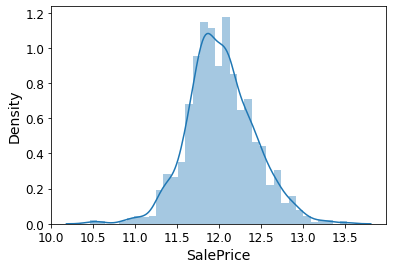

In [12]:
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
sns.distplot(train_df['SalePrice']);

In [13]:
# Drop Id column, and the target variable

train = train_df.drop('Id', axis=1)

test_ids = test_df['Id'].copy()
test = test_df.drop('Id', axis=1)

train.loc[:,'Train'] = 1
test.loc[:,'Train'] = 0

housing_df = pd.concat([train,test], ignore_index=True)

train_labels = train["SalePrice"].copy()
train = train.drop("SalePrice", axis=1) # drop labels for training set

In [14]:
#### Type of features

train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

num_attribs = train.select_dtypes([np.number]).columns

cat_attribs = train.select_dtypes(include=[np.object]).columns

print('numerical:{} \n\n categorical:{}'.format(num_attribs, cat_attribs))

numerical:Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'Train'],
      dtype='object') 

 categorical:Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2

In [15]:
# Log transform the columns with high skew

skewed_cols = num_attribs[train[num_attribs].skew() > 0.75]
train[skewed_cols] = np.log1p(train[skewed_cols])
test[skewed_cols] = np.log1p(test[skewed_cols])

train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Train
0,60,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal,1
1,20,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal,1
2,60,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal,1
3,70,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml,1
4,60,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal,1


In [16]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore',sparse=False)),
    ])

In [17]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

train_prepared = full_pipeline.fit_transform(train)

In [18]:
train_prepared.shape

(1460, 303)

In [19]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1)
ridge_reg.fit(train_prepared, train_labels)

Ridge(alpha=0.1)

In [20]:
from sklearn.metrics import mean_squared_error

train_predictions = ridge_reg.predict(train_prepared)
ridge_mse = mean_squared_error(train_labels, train_predictions)
ridge_rmse = np.sqrt(ridge_mse)
print('rmse on training:', ridge_rmse)

rmse on training: 0.09205067463579863


In [21]:
test_prepared = full_pipeline.transform(test)
test_predictions = ridge_reg.predict(test_prepared)
test_predictions = np.expm1(test_predictions)
# test_predictions

In [22]:
def prep_to_submit(ids, preds, fname='submission.csv'):
    preds = pd.DataFrame({'Id': ids, 'SalePrice': preds})
    preds.to_csv(fname, index=False)

In [23]:
prep_to_submit(test_ids, test_predictions, fname='submission_ridge.csv')
print('this submission scored: ', 0.13636)

this submission scored:  0.13636


*Looks like the model did not generalize well to the unseen data*

### Q3-3.  Ridge vs Lasso / Hyperparameter tuning

In [24]:
## LASSO

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(train_prepared, train_labels)

train_predictions = lasso_reg.predict(train_prepared)
lasso_mse = mean_squared_error(train_labels, train_predictions)
lasso_rmse = np.sqrt(lasso_mse)
print('At alpha=0.1: ridge_rmse: {}, lasso_rmse: {}'.format(ridge_rmse, lasso_rmse))

At alpha=0.1: ridge_rmse: 0.09205067463579863, lasso_rmse: 0.21490794092143337


*With the current parameters, ridge seems to perform better*

In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]}]

ridge_reg = Ridge()
lasso_reg = Lasso()

ridge_grid = GridSearchCV(ridge_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
lasso_grid = GridSearchCV(lasso_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

ridge_grid.fit(train_prepared, train_labels)
lasso_grid.fit(train_prepared, train_labels)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid=[{'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                    0.1, 0.5, 1, 5, 10, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
for mean_score, params in zip(ridge_grid.cv_results_["mean_test_score"], ridge_grid.cv_results_["params"]):
    print(np.sqrt(-mean_score), params)

0.1399970837102057 {'alpha': 0.0001}
0.13998204621902183 {'alpha': 0.0005}
0.1399633307946899 {'alpha': 0.001}
0.13981676882387867 {'alpha': 0.005}
0.13964103284947976 {'alpha': 0.01}
0.13846589331037493 {'alpha': 0.05}
0.13737323826877734 {'alpha': 0.1}
0.1332081052374154 {'alpha': 0.5}
0.1310301522816308 {'alpha': 1}
0.12710067218711385 {'alpha': 5}
0.12635262327819696 {'alpha': 10}
0.12737402268099124 {'alpha': 50}
0.12913962093195266 {'alpha': 100}


In [27]:
for mean_score, params in zip(lasso_grid.cv_results_["mean_test_score"], lasso_grid.cv_results_["params"]):
    print(np.sqrt(-mean_score), params)

0.12867433485980362 {'alpha': 0.0001}
0.12324352807097559 {'alpha': 0.0005}
0.12471209745978114 {'alpha': 0.001}
0.13770486393277845 {'alpha': 0.005}
0.14174476400931235 {'alpha': 0.01}
0.17330675179361027 {'alpha': 0.05}
0.21613648276820197 {'alpha': 0.1}
0.39956841578485275 {'alpha': 0.5}
0.39956841578485275 {'alpha': 1}
0.39956841578485275 {'alpha': 5}
0.39956841578485275 {'alpha': 10}
0.39956841578485275 {'alpha': 50}
0.39956841578485275 {'alpha': 100}


In [28]:
print('At tuned alphas - best scores: ridge_rmse: {}, lasso_rmse: {}'.format(min(np.sqrt(-ridge_grid.cv_results_['mean_test_score'])), min(np.sqrt(-lasso_grid.cv_results_['mean_test_score']))))

At tuned alphas - best scores: ridge_rmse: 0.12635262327819696, lasso_rmse: 0.12324352807097559


*With the tuned alphas, lasso performed slightly better*

In [29]:
from sklearn.model_selection import cross_val_score

def display_scores(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, n_jobs=-1, scoring='neg_mean_squared_error', cv=cv)
    print(str(model.__class__.__name__) + '; mean_rmse: {}'.format((np.sqrt(-scores)).mean()) + ', std_rmse: {}'.format((np.sqrt(-scores)).std()))

### Q3-4. Number of nonzero coefficients Lasso vs regularization parameter

In [30]:
alphas = [1e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
num_nonzeros = []
for alpha in alphas:
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(train_prepared, train_labels)
    num_nonzeros.append(sum(lasso_reg.coef_>1e-3))  

Text(0, 0.5, 'nonzero coefficient count')

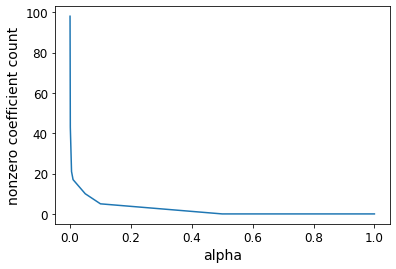

In [31]:
plt.plot(alphas, num_nonzeros)
plt.xlabel('alpha')
plt.ylabel('nonzero coefficient count')

### Q3-5. Ensembling and Stacking

In [32]:
from sklearn.ensemble import StackingRegressor

estimators = [('r', ridge_grid),
              ('l', lasso_grid)
             ]

stacking_model = StackingRegressor(estimators=estimators, passthrough=True)

In [33]:
stacking_model.fit(train_prepared, train_labels);

In [34]:
display_scores(stacking_model, train_prepared, train_labels)

StackingRegressor; mean_rmse: 0.12201283432947767, std_rmse: 0.02157228760282766


In [35]:
test_prepared = full_pipeline.transform(test)
test_predictions = stacking_model.predict(test_prepared)
test_predictions = np.expm1(test_predictions)

prep_to_submit(test_ids, test_predictions, fname='submission_stacking_model.csv')

In [36]:
print('Score from the described stacking method in the problem: ', 0.13344)

Score from the described stacking method in the problem:  0.13344


### Q3-6. XGBoost

In [37]:
import xgboost

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'max_depth': randint(low=1, high=20),
        'eta': [0.01, 0.05, 0.1, 0.5, 1],
        'subsample' : [0.1, 0.25, 0.5, 0.75, 1],
        'n_estimators' : randint(low=150, high=500),
    }

xgb_reg = xgboost.XGBRegressor(silent=True, early_stopping_rounds=5)

rnd_search = RandomizedSearchCV(xgb_reg, param_distributions=param_distribs,
                                n_iter=20, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_prepared, train_labels)

[15:49:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=5, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints...
                                          validate_parameters=None,
                                          verbosity=None),
                   n_iter=20, n_jobs=-1,
                   para

In [38]:
display_scores(rnd_search, train_prepared, train_labels)

RandomizedSearchCV; mean_rmse: 0.12709837151975073, std_rmse: 0.01698834128327335


### Q3-7. Get more accurate model

In [39]:
#from part 1

save_path = 'saved_models/'
os.makedirs(save_path, exist_ok=True)

def load_data(data_path='data/'):
    train = os.path.join(data_path, "train.csv")
    test = os.path.join(data_path, "test.csv")
    return pd.read_csv(train), pd.read_csv(test)

import joblib
def save_model(model, fname="model.pkl"):
    joblib.dump(model, os.path.join(save_path,fname))
def load_model(fname):
    return joblib.load(os.path.join(save_path,fname))

from sklearn.model_selection import cross_val_score
def display_scores(model, X, y, cv=10):
    scores = cross_val_score(model, X, y, n_jobs=-1, scoring='neg_mean_squared_error', cv=cv)
    print(str(model.__class__.__name__) + '; mean_rmse: {:.4f} w std ({:.4f})'.format((np.sqrt(-scores)).mean(), (np.sqrt(-scores)).std()))
    return scores 

def prep_to_submit(ids, test, model):
    prepared = full_pipeline.transform(test)
    preds = model.predict(prepared)
    preds = np.expm1(preds)
    preds_df = pd.DataFrame({'Id': ids, 'SalePrice': preds})
    preds_df.to_csv(model.__class__.__name__ + '_preds.csv', index=False)

In [40]:
train_df, test_df = load_data()

test_ids = test_df['Id'].copy()

train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

# train_df.loc[:,'Train'] = 1
# test_df.loc[:,'Train'] = 0
# test_df['SalePrice'] = 0
# df = pd.concat([train,test], ignore_index=True)

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


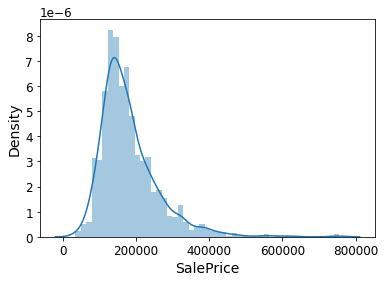

In [41]:
sns.distplot(train_df['SalePrice']);

looks skewed, lets apply log transform to get a more normal looking distribtuion

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


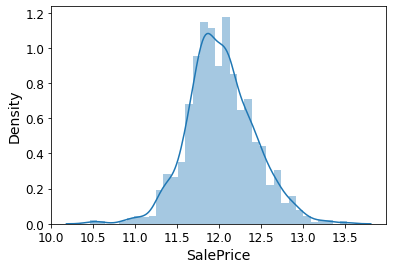

In [42]:
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])
sns.distplot(train_df['SalePrice']);

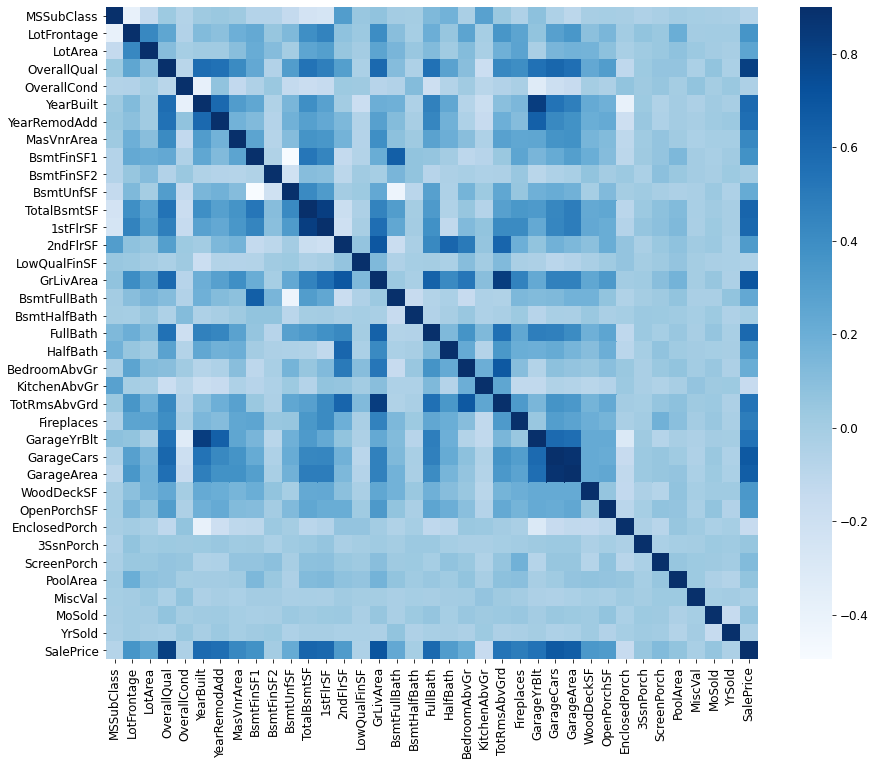

In [43]:
corrmat = train_df.corr()
plt.subplots(figsize=(15,12));
sns.heatmap(corrmat, vmax=0.9, cmap="Blues", square=True);

In [44]:
corrmat['SalePrice'].sort_values(ascending=False)[:10]

SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
Name: SalePrice, dtype: float64

Let's investigate highly correlated features

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


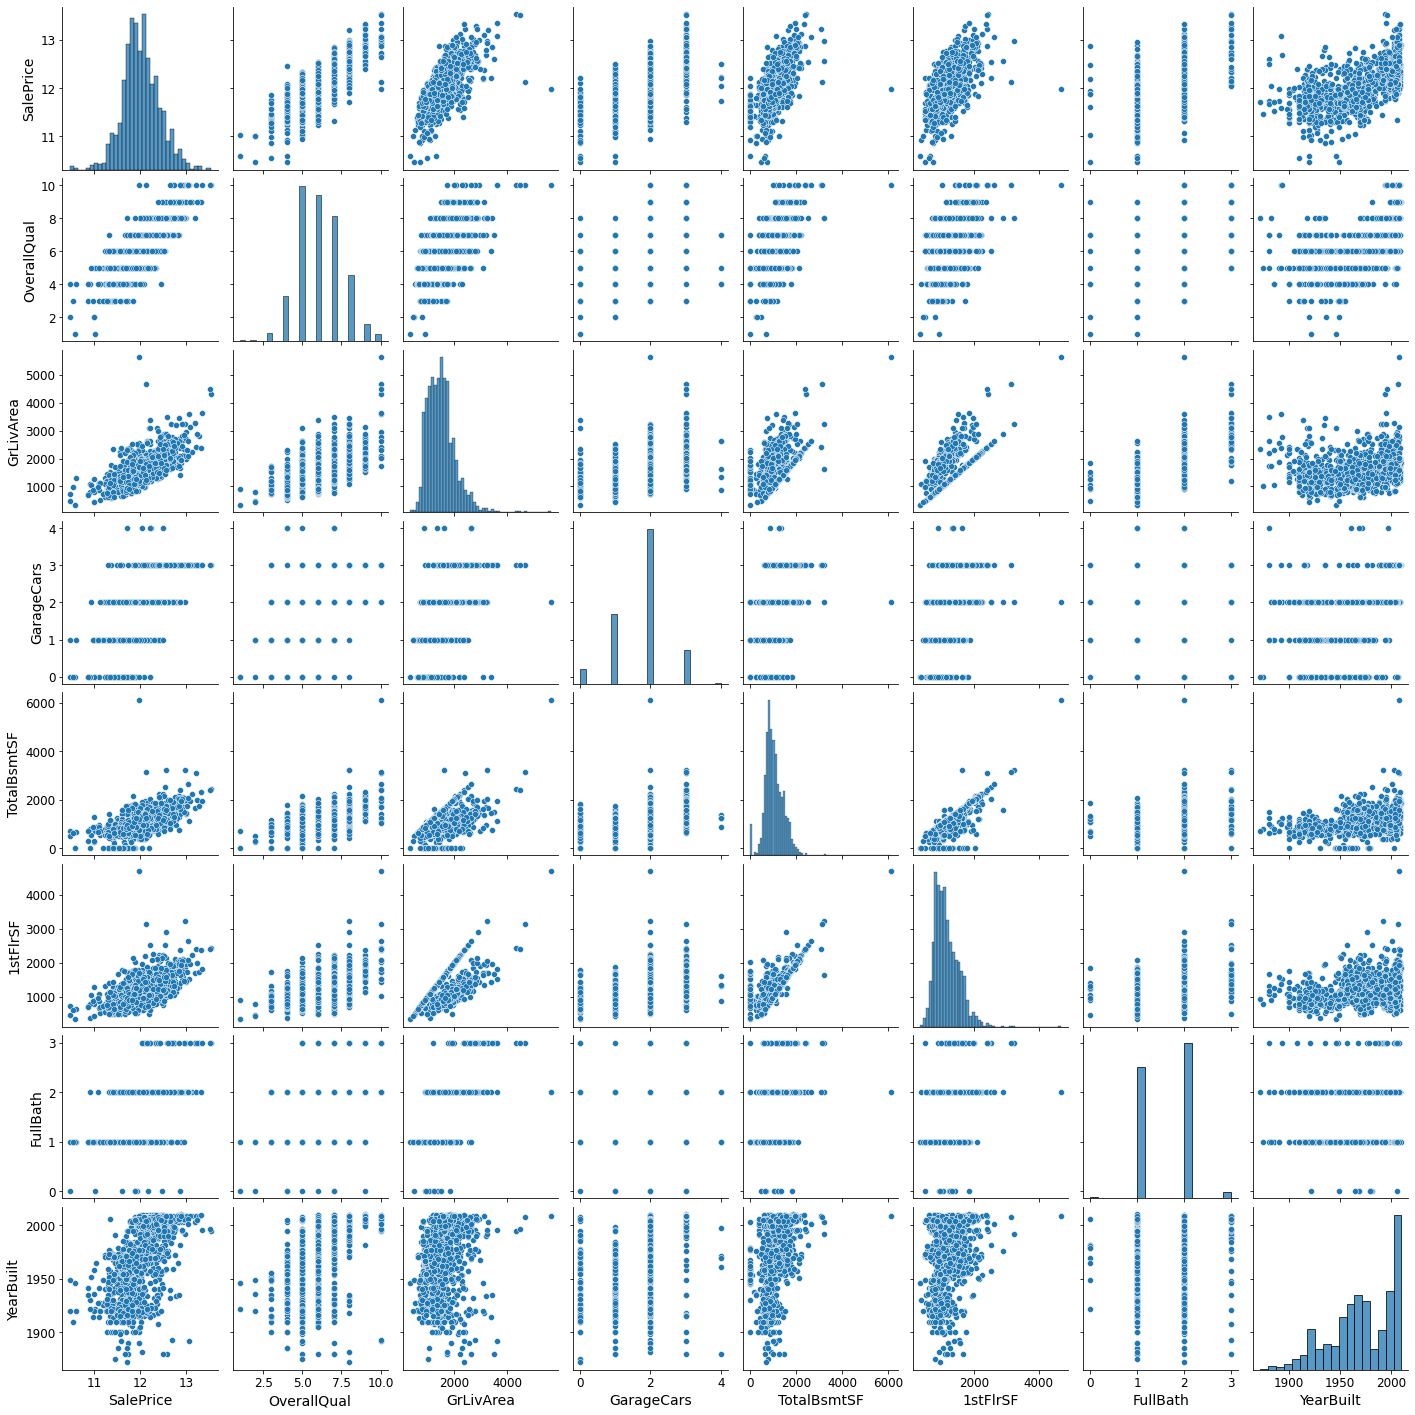

In [45]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

- There are 2 data points in GrLiveArea vs Sale Price that looks like an outlier
- There is also another data point in TotalBsmtSF vs Sale price taht looks like an outlier

Lets deal with these

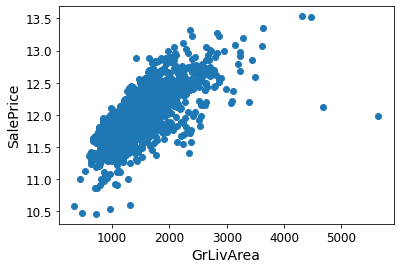

In [46]:
plt.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('GrLivArea')
plt.show()

lets drop those 2 examples that looks a lot like outliers

In [47]:
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<12.5)].index)

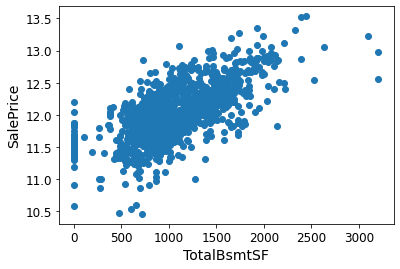

In [48]:
plt.scatter(x = train_df['TotalBsmtSF'], y = train_df['SalePrice'])
plt.ylabel('SalePrice')
plt.xlabel('TotalBsmtSF')
plt.show()

That data point looked like an outlier to TotalBsmtSF was the same point we just dropped - so we are good

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

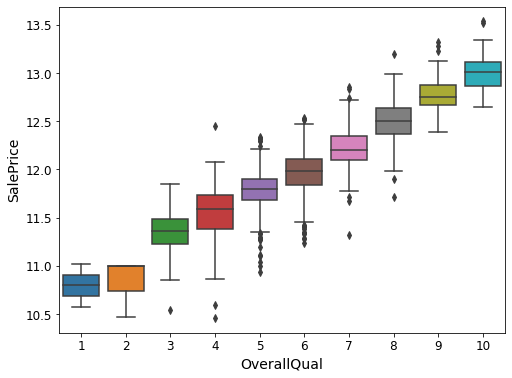

In [49]:
# feature OverallQual
plt.subplots(figsize=(8, 6))
sns.boxplot(x=train_df['OverallQual'], y=train_df["SalePrice"])

Lets treat this as a category rather than a numerical value

In [50]:
train_df['OverallCond'] = train_df['OverallCond'].astype(str)
test_df['OverallCond'] = test_df['OverallCond'].astype(str)

In [51]:
train_labels = train_df['SalePrice'].copy()

train = train_df.drop('SalePrice', axis=1)
test = test_df.copy()

In [52]:
cat_attribs = train.select_dtypes(include=[np.object]).columns
train[cat_attribs].describe(include='all')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1458,1458,91,1458,1458,1458,1458,1458,1458,1458,...,1377,1377,1377,1377,1458,6,281,54,1458,1458
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1149,1452,50,925,1311,1457,1051,1380,225,1260,...,869,605,1309,1324,1338,2,157,49,1267,1198


In [53]:
train['Street'].value_counts()

Pave    1452
Grvl       6
Name: Street, dtype: int64

In [54]:
train['Utilities'].value_counts()

AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64

lets drop the above two categorical features, there is no variation no information here to learn from

In [55]:
train.drop(columns=['Utilities', 'Street'], inplace=True)
test.drop(columns=['Utilities', 'Street'], inplace=True)

In [56]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1452,0.995885
MiscFeature,1404,0.962963
Alley,1367,0.937586
Fence,1177,0.807270
FireplaceQu,690,0.473251
LotFrontage,259,0.177641
GarageType,81,0.055556
GarageCond,81,0.055556
GarageFinish,81,0.055556
GarageQual,81,0.055556


In [57]:
# From the description of data MSSubClass looks like a categorical value
train[['MSSubClass', 'YrSold', 'MoSold']] = train[['MSSubClass', 'YrSold', 'MoSold']].astype(str)
test[['MSSubClass', 'YrSold', 'MoSold']] = test[['MSSubClass', 'YrSold', 'MoSold']].astype(str) 

### Handling missing values

In [58]:
#From: got ideas from https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb

def fix_nas(df):
    #Fill na for these column with standard equipment for those - intuition from data description.txt
    df['Functional'] = df['Functional'].fillna('Typ') 
    df['Electrical'] = df['Electrical'].fillna('SBrkr')
    df['KitchenQual'] = df['KitchenQual'].fillna('TA')
    df['SaleType'] = df['SaleType'].fillna('Other')
    df['Exterior1st'] = df['Exterior1st'].fillna('Other')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Other')
    
    #None for not exists - intuition from data description.txt
    df['PoolQC'] = df['PoolQC'].fillna('None')
    
    #These two are probably very related
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #Na means No Garage
    for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
        df[col] = df[col].fillna(0)
    
    #Na means No Garage 
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        df[col] = df[col].fillna('None')
    
    #Na means there's no basement
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].fillna('None')
    
    #Na means no basement, so the measurement is 0
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        df[col] = df[col].fillna(0)
        
    for col in train.select_dtypes(include=[np.object]).columns:
        df[col] = df[col].fillna('None')
        
    for col in train.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(0)
    
    return df

In [59]:
train_df = fix_nas(train_df)
test_df = fix_nas(test_df)

### Handle skewness of data

In [60]:
num_attribs = train.select_dtypes([np.number]).columns

skewed_cols = num_attribs[train[num_attribs].skew() > 0.7]
train[skewed_cols] = np.log1p(train[skewed_cols])
test[skewed_cols] = np.log1p(test[skewed_cols])

### Feature Engineering

In [61]:
def combine_features(df):
    
    # Exists or not
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    #Unfinished or not
    df['BsmtFinType1_Unf'] = 1*(df['BsmtFinType1'] == 'Unf')
    
    df['OldHouse'] = df['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)
    
    #Some aggregated features
    df['TotalSF']=df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                            df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))
    df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                          df['EnclosedPorch'] + df['ScreenPorch'] +
                          df['WoodDeckSF'])
    
    
  
    df['Age_YrBuilt'] = df['YrSold'] - df['YearBuilt']
    df['Age_YrRemod'] = df['YrSold'] - df['YearRemodAdd']
    df['Age_Garage'] = df['YrSold'] - df['GarageYrBlt']
    df['Remodeled'] = df['YearBuilt']!=df['YearRemodAdd']

    #to fix if the garageyrbuilt is 0 for example - its 0 if garage was never built
    df['Age_YrBuilt'] = df['Age_YrBuilt'].apply(lambda x: 0 if x <0 else x)
    df['Age_YrRemod'] = df['Age_YrRemod'].apply(lambda x: 0 if x <0 else x)
    df['Age_Garage'] = df['Age_Garage'].apply(lambda x: 0 if x <0 else x)
        
    
    return df

In [62]:
train_df = combine_features(train_df)
test_df = combine_features(test_df)

In [63]:
corrmat = train_df.corr()
corrmat['SalePrice'].sort_values(ascending=False)[:25]

SalePrice         1.000000
TotalSF           0.825326
OverallQual       0.821405
GrLivArea         0.725211
GarageCars        0.681033
TotalBathrooms    0.676678
GarageArea        0.656129
TotalBsmtSF       0.647563
1stFlrSF          0.620500
FullBath          0.595899
YearBuilt         0.587043
YearRemodAdd      0.565992
TotRmsAbvGrd      0.537702
HasFireplace      0.510253
Fireplaces        0.491998
MasVnrArea        0.430570
TotalPorchSF      0.399695
BsmtFinSF1        0.392283
GarageYrBlt       0.349013
WoodDeckSF        0.334251
OpenPorchSF       0.325215
HasGarage         0.322994
2ndFlrSF          0.319953
HalfBath          0.314186
LotArea           0.260544
Name: SalePrice, dtype: float64

In [64]:
corrmat['SalePrice'].sort_values(ascending=True)[:25]

OldHouse           -0.595325
Age_YrBuilt        -0.587767
Age_YrRemod        -0.568529
Age_Garage         -0.349109
EnclosedPorch      -0.149029
KitchenAbvGr       -0.147534
BsmtFinType1_Unf   -0.097133
Remodeled          -0.074066
MSSubClass         -0.073969
LowQualFinSF       -0.037951
YrSold             -0.037151
MiscVal            -0.020012
BsmtHalfBath       -0.005124
BsmtFinSF2          0.004863
3SsnPorch           0.054914
MoSold              0.057064
PoolArea            0.074338
HasPool             0.076516
ScreenPorch         0.121245
Has2ndfloor         0.150568
LotFrontage         0.183182
HasBsmt             0.199626
BedroomAbvGr        0.209035
BsmtUnfSF           0.221892
BsmtFullBath        0.237099
Name: SalePrice, dtype: float64

In [65]:
#Lets drop the two least correlated features
train.drop(columns=['BsmtFinSF2', 'BsmtHalfBath'], inplace=True)
test.drop(columns=['BsmtFinSF2', 'BsmtHalfBath'], inplace=True)

In [66]:
#### Type of features
num_attribs = train.select_dtypes([np.number]).columns

ord_attribs = list(['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope', 'YrSold', 'MoSold'])

cat_attribs = train.select_dtypes(include=[np.object]).columns

print('numerical:{} \n\n categorical:{}'.format(num_attribs, cat_attribs))

numerical:Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal'],
      dtype='object') 

 categorical:Index(['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional'

### Prep data for models

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="mean")),
        ('std_scaler', RobustScaler()),
    ])

# ord_pipeline = Pipeline([
#         ("imputer", SimpleImputer(strategy="most_frequent")),
#         ("encoder", OrdinalEncoder()),
#     ])

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore',sparse=False)),
    ])



In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

full_pipeline = ColumnTransformer([
#         ("ord", ord_pipeline, ord_attribs),
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [69]:
train_prepared = full_pipeline.fit_transform(train)

In [70]:
train_prepared.shape

(1458, 318)

### Model selection

In [71]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

ridge_reg = Ridge(max_iter=3000)
lasso_reg = Lasso(max_iter=3000)

param_grid = [{'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}]

ridge_grid = GridSearchCV(ridge_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
lasso_grid = GridSearchCV(lasso_reg, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

ridge_grid.fit(train_prepared, train_labels)
lasso_grid.fit(train_prepared, train_labels)

GridSearchCV(cv=10, estimator=Lasso(max_iter=3000),
             param_grid=[{'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                    0.1, 0.5, 1, 5, 10, 50]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [72]:
lasso_scores = display_scores(lasso_grid.best_estimator_, train_prepared, train_labels)
ridge_scores = display_scores(ridge_grid.best_estimator_, train_prepared, train_labels)

Lasso; mean_rmse: 0.1092 w std (0.0144)
Ridge; mean_rmse: 0.1104 w std (0.0134)


In [73]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(min_samples_leaf=6, max_depth=4, max_features='sqrt', subsample=0.8, warm_start=True)
X_train, X_val, y_train, y_val = train_test_split(train_prepared, train_labels)

min_val_error = np.inf
err_up = 0
for n_estimators in range(1,1000):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        err_up = 0
    else:
        err_up += 1
        if err_up == 5:
            break

## Found the values by cheking cross val scores with the below cell - couldnt run grid search as I had to do the loop for early stopping
## so ended up doing the grid search manually for good parameters

In [74]:
gbrt_scores = display_scores(gbrt, train_prepared, train_labels)

GradientBoostingRegressor; mean_rmse: 0.1175 w std (0.0157)


In [98]:
from sklearn.svm import SVR

param_grid = [
#         {'kernel': ['linear'], 'C': [0.1, 1, 10, 20]},
        {'kernel': ['rbf'], 'C': [0.01, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0], 'gamma': [1e-6, 0.00001, 0.0003, 0.0001, 0.003, 0.01, 0.03, 0.1]},
    ]

svm_reg = SVR()
svm_grid = GridSearchCV(svm_reg, param_grid, cv=7, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
svm_grid.fit(train_prepared, train_labels)

Fitting 7 folds for each of 72 candidates, totalling 504 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:   46.4s finished


GridSearchCV(cv=7, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.01, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0,
                                1000.0, 3000.0],
                          'gamma': [1e-06, 1e-05, 0.0003, 0.0001, 0.003, 0.01,
                                    0.03, 0.1],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [99]:
svm_scores = display_scores(svm_grid.best_estimator_, train_prepared, train_labels, cv=7)

SVR; mean_rmse: 0.1137 w std (0.0073)


In [100]:
from sklearn.ensemble import RandomForestRegressor



Fitting 7 folds for each of 648 candidates, totalling 4536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1029 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1474 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2001 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 3297 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4536 out of 4536 | elapsed:  9.2min finished


GridSearchCV(cv=7, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'max_depth': [3, 8, 16],
                         'max_features': [8, 16, 32],
                         'min_samples_leaf': [2, 3, 5, 8],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [50, 100, 500]},
             scoring='neg_mean_squared_error', verbose=2)

In [101]:
rf_scores = display_scores(rf_grid.best_estimator_, train_prepared, train_labels, cv=7)

RandomForestRegressor; mean_rmse: 0.1340 w std (0.0089)


In [102]:
import xgboost

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
param_distribs = {
        'max_depth': randint(low=3, high=20),
        'eta': [0.01, 0.05, 0.1],
        'subsample' : [0.8, 1],
        'colsample_bytree' : [0.3, 0.5, 0.8],
        'n_estimators' : randint(low=400, high=1000),
        'min_child_weight' : np.arange(1,6,2)
    }

xgb_reg = xgboost.XGBRegressor(silent=True, early_stopping_rounds=5)

xgb_grid = RandomizedSearchCV(xgb_reg, param_distributions=param_distribs,
                                n_iter=100, cv=7, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
xgb_grid.fit(train_prepared, train_labels);

[18:00:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { early_stopping_rounds, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [103]:
xgb_scores = display_scores(xgb_grid.best_estimator_, train_prepared, train_labels, cv=7)

XGBRegressor; mean_rmse: 0.1136 w std (0.0087)


In [111]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, LassoCV

estimators = [('r', ridge_grid.best_estimator_),
              ('l', lasso_grid.best_estimator_),
              ('boost', gbrt),
              ('svm', svm_grid.best_estimator_),
              ('rf', rf_grid.best_estimator_),
              ('xgb', xgb_grid.best_estimator_)
             ]

alphas = [0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]

stack = StackingRegressor(estimators=estimators, final_estimator=LassoCV(alphas=alphas), n_jobs=-1, passthrough=True)
stack_2 = StackingRegressor(estimators=estimators, final_estimator=LassoCV(alphas=alphas), n_jobs=-1, passthrough=False)

In [112]:
display_scores(stack, train_prepared, train_labels)

StackingRegressor; mean_rmse: 0.1119 w std (0.0142)


array([-0.01334942, -0.01080404, -0.01180723, -0.01497546, -0.02081403,
       -0.01005647, -0.01195097, -0.00857897, -0.0099927 , -0.01499788])

In [113]:
stack_scores = display_scores(stack_2, train_prepared, train_labels, cv=7)

StackingRegressor; mean_rmse: 0.1076 w std (0.0086)


In [114]:
model = stack_2

In [115]:
model.fit(train_prepared, train_labels)
prepared = full_pipeline.transform(test)

preds = model.predict(prepared)
# preds = blended_predictions(prepared)
preds_transformed = np.expm1(preds)
preds_df = pd.DataFrame({'Id': test_ids, 'SalePrice': preds_transformed})
preds_df.to_csv('submission_' + model.__class__.__name__ + '.csv', index=False)

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.084271157624773, tolerance: 0.018911334381783326
  tol, rng, random, positive)
/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3433894858325992, tolerance: 0.017996952084854276
  tol, rng, random, positive)
/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9383585746349521, tolerance: 0.01837208344628372
  tol, rng, random, positive)
/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/lin

In [116]:
from sklearn.metrics import mean_squared_error

model.fit(train_prepared, train_labels)
train_preds = model.predict(train_prepared)
# train_preds = blended_predictions(train_prepared)
mse = mean_squared_error(train_labels, train_preds)
rmse = np.sqrt(mse)
rmse

/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20107241666009656, tolerance: 0.017996952084854276
  tol, rng, random, positive)
/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7092595676892355, tolerance: 0.01837208344628372
  tol, rng, random, positive)
/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7389989253225, tolerance: 0.019012728260948034
  tol, rng, random, positive)
/Users/cgokalp/anaconda/envs/ds_lab/lib/python3.7/site-packages/sklearn/line

0.06706749842160246

### Save models

In [117]:
models = [ridge_grid, lasso_grid, xgb_grid, svm_grid, gbrt, rf_grid, stack]
for model in models:
    save_model(model, fname=model.__class__.__name__ + '.pkl')

Best public score we got was **0.12397**